# Исследование объявлений о продаже квартир
В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Для решения этих задач необходимо разбить проект на несколько этапов:
1. Предобработка данных:
- найти и обработать пропуски
- заменить некорректные типы данных
- удалить дубликаты
- подсчитать и добавить цену квадратного метра
- добавить день недели, месяц и год объявления
- добавить этаж - первый, последний, другой
- добавить соотношение жилой и общей площади, а также отношение площади кухни к общей

2. Анализ данных:
- Выяснить типичные параметры продаваемых квартир (например, площадь, цена).
- Указать их характеристики и построить графики.
- Узнать, сколько обычно длится процесс продажи.
- Выяснить, какие факторы больше всего влияют на стоимость квартиры.
- Изучить зависит ли цена квадратного метра от числа комнат, этажа (первого или последнего), удалённости от центра и даты размещения: дня недели, месяца и года.
- Выбрать 10 населённых пунктов с наибольшим числом объявлений.
- Выделить квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислить среднюю цену каждого километра.
- Описать, как стоимость объектов зависит от расстояния до центра города

3. Общий вывод.


## 1. Откройте файл с данными и изучите общую информацию. 


### 1.1 Загрузите данные из файла в датафрейм.


In [ ]:
import pandas as pd
import seaborn as sn
#import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv' , sep='\t')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00


### 1.2 Изучите общую информацию о полученном датафрейме.


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Почти во всех столбцах имеются пропуски. При дальнейшем анализе часть пропусков будет удалена, часть заменена. В случае невозможности замены или удаления, остальные будут оставлены.

In [ ]:
# Выведем основную статистическую информацию по столбцам
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.00,23699.00,23699.00,23699.00,14504.00,23613.00,21796.00,23699.00,21421.00,12180.00,18157.00,18180.00,18181.00,8079.00,18181.00,9110.00,20518.00
mean,9.86,6541548.77,60.35,2.07,2.77,10.67,34.46,5.89,10.57,1.15,28793.67,14191.28,0.61,490.80,0.77,517.98,180.89
std,5.68,10887013.27,35.65,1.08,1.26,6.60,22.03,4.89,5.91,1.07,12630.88,8608.39,0.80,342.32,0.94,277.72,219.73
min,0.00,12190.00,12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3400000.00,40.00,1.00,2.52,5.00,18.60,2.00,7.00,0.00,18585.00,9238.00,0.00,288.00,0.00,294.00,45.00
50%,9.00,4650000.00,52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,26726.00,13098.50,0.00,455.00,1.00,502.00,95.00
75%,14.00,6800000.00,69.90,3.00,2.80,16.00,42.30,8.00,12.00,2.00,37273.00,16293.00,1.00,612.00,1.00,729.00,232.00
max,50.00,763000000.00,900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


### 1.3 Постройте общую гистограмму для всех столбцов таблицы

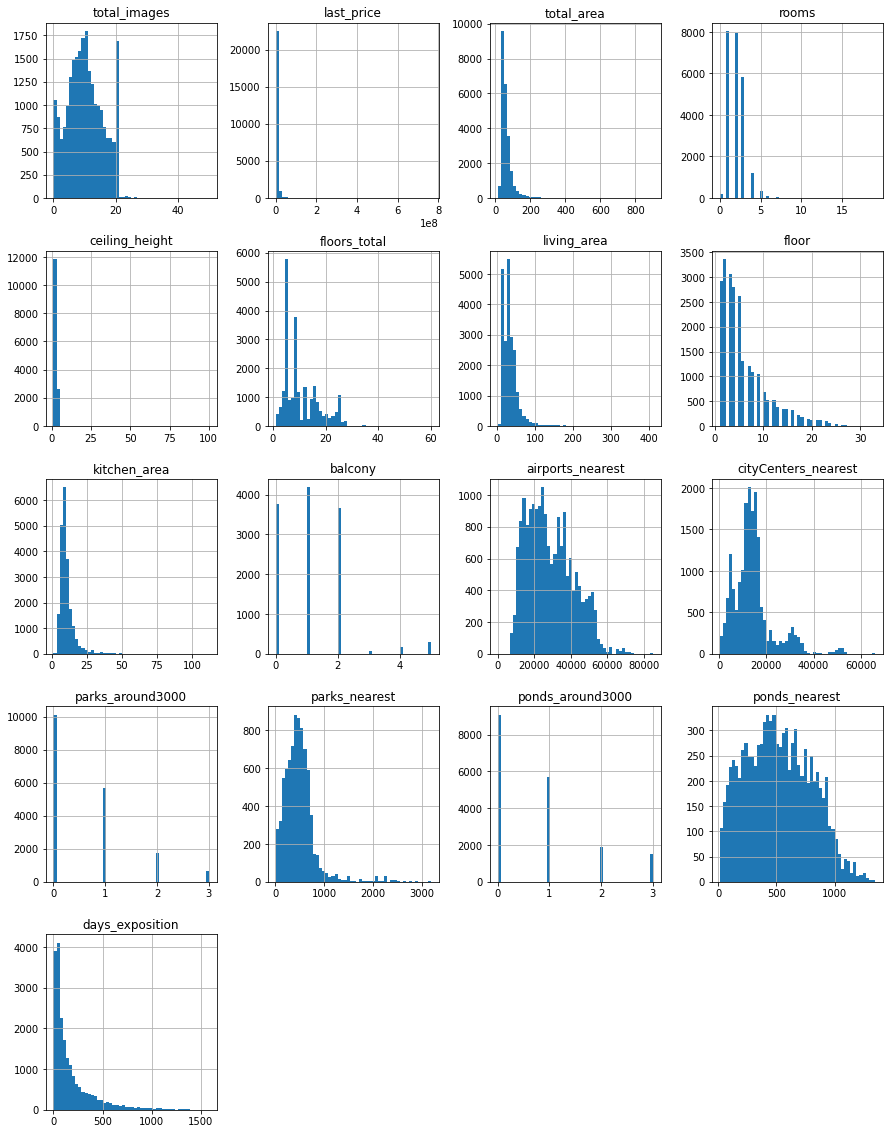

In [ ]:
data.hist(bins=50, figsize=(15,20));


## 2. Предобработка данных


### 2.1 Найдите и изучите пропущенные значения в столбцах: Определите, в каких столбцах есть пропуски.


In [ ]:
print(data.isnull().sum().sort_values())

total_images                0
open_plan                   0
floor                       0
rooms                       0
studio                      0
total_area                  0
last_price                  0
first_day_exposition        0
locality_name              49
floors_total               86
living_area              1903
kitchen_area             2278
days_exposition          3181
ponds_around3000         5518
parks_around3000         5518
cityCenters_nearest      5519
airports_nearest         5542
ceiling_height           9195
balcony                 11519
ponds_nearest           14589
parks_nearest           15620
is_apartment            20924
dtype: int64


In [ ]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

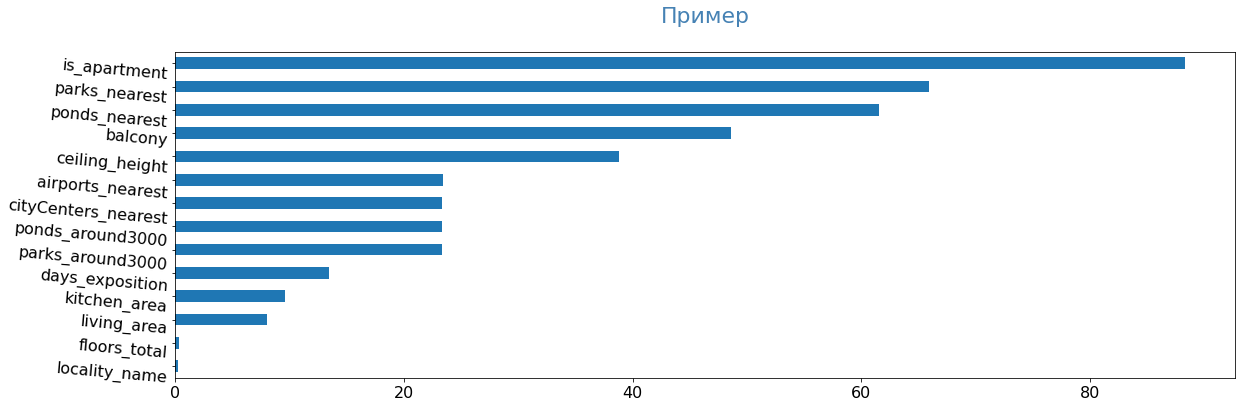

In [ ]:
pass_value_barh(data)

### 2.2 Рассмотрите типы данных в каждом столбце. Найдите столбцы, в которых нужно изменить тип данных. Преобразуйте тип данных в выбранных столбцах.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### Семь столбцов имеют нессответвующий тип данных:

 1.  first_day_exposition - object - дата публикации должен иметь тип данных datetime
 2.  floors_total - float64 - количество этажей выражается через целое число
 3.  is_apartment - object - апартаменты или есть или их нет - булев тип данных
 4.  balcony - float64- количество балконов не может быть дробным, только целое число
 5.  parks_around3000 - float64 - количество парков поблизости не может быть дробным, только целое число
 6.  ponds_around3000 - float64 - количество прудов поблизости не может быть дробным, только целое число
 7.  days_exposition - float64 -дней публикации не может быть дробным, только целое число
Приведем указанные столбцы к соответствующим типам данных


In [ ]:
try:
  data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d') #T%H:%M:%S
  print(data['first_day_exposition'].head())
except:
  print('Unknown_error') 


0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]


Так как в столбцах, которые имеют несоответствующий тип данных имеются пропуски - их нельзя преобразовать. Тип данных в них будет изменён после удаления пропусков.

In [ ]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

### 2.3 Заполните пропущенные значения там, где это возможно. В ячейке с типом markdown укажите причины, которые могли привести к пропускам в данных. 

       parks_around3000  parks_nearest
19208              0.00        3013.00
1590               0.00        3064.00
10959              0.00        3190.00
19430              0.00        3190.00
1                  0.00            NaN
6                  0.00            NaN
7                  0.00            NaN
9                  0.00            NaN
11                 0.00            NaN
14                 0.00            NaN

    ponds_around3000  ponds_nearest
1               0.00            NaN
6               0.00            NaN
7               0.00            NaN
9               0.00            NaN
11              0.00            NaN
16              0.00            NaN
18              0.00            NaN
19              0.00            NaN
20              0.00            NaN
21              0.00            NaN


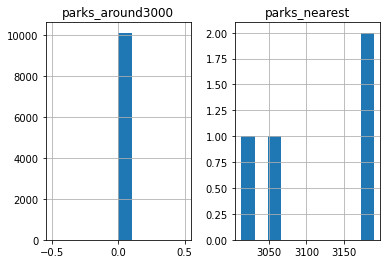

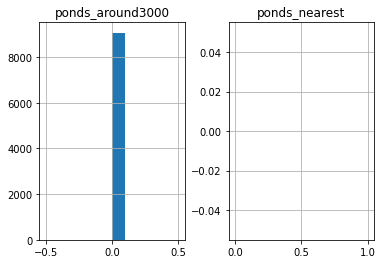

In [ ]:
#Рассмотрим, есть ли в парных столбцах взаимосвязь. ПРУДЫ И ПАРКИ
nan_parks = data[['parks_around3000', 'parks_nearest']].query('parks_around3000==0')
nan_ponds = data[['ponds_around3000', 'ponds_nearest']].query('ponds_around3000==0')

nan_parks.hist()
nan_ponds.hist()
print(nan_parks.sort_values(by='parks_nearest').head(10))
print()
print(nan_ponds.sort_values(by='ponds_nearest').head(10))

Исходя из выведенной сортировки по срезу и гистограмм имеем то, что во всех случаях, где одно из значений столбца NaN, второе тоже является NaN. Это означает, что парков и прудов рядом с таким жильем нет. Поэтому заполняем их значением 0.

Так же на выведенном списке и на гистаграммах заметны выбросы в виде ~3000 парков поблизости от жилья, чего не может быть. Для последующего анализа такие выбросы необходимо убрать из таблицы.



In [ ]:
data['parks_nearest'] = data['parks_nearest'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)

data['parks_around3000'].astype('int')
data['ponds_around3000'].astype('int')

0        2
1        0
2        2
3        3
4        1
        ..
23694    3
23695    0
23696    0
23697    3
23698    0
Name: ponds_around3000, Length: 23699, dtype: int64

### 2.4 Найдите и устраните редкие и выбивающиеся значения.  В ячейке с типом markdown опишите, какие особенности в данных вы обнаружили

#### Столбец высота потолков

36


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
552,11,2999000.00,33.50,2017-03-30,1,2.00,15.00,17.50,6,NaN,...,6.50,NaN,Санкт-Петербург,33972.00,11746.00,1.00,520.00,1.00,949.00,270.00
1582,4,4100000.00,45.60,2016-01-13,2,2.30,9.00,28.40,8,False,...,7.00,2.00,Санкт-Петербург,49152.00,14977.00,1.00,489.00,1.00,525.00,329.00
2572,4,2400000.00,62.00,2018-12-27,3,2.00,5.00,40.00,4,NaN,...,6.00,1.00,Луга,NaN,NaN,0.00,0.00,0.00,0.00,NaN
4212,1,2120000.00,35.43,2017-12-18,1,2.00,18.00,16.60,9,NaN,...,8.80,2.00,Тосно,NaN,NaN,0.00,0.00,0.00,0.00,36.00
5498,17,2200000.00,56.00,2018-04-02,2,2.30,5.00,45.00,1,NaN,...,9.00,2.00,Сясьстрой,NaN,NaN,0.00,0.00,0.00,0.00,55.00
5712,5,1500000.00,42.80,2017-08-14,2,1.20,2.00,27.50,1,NaN,...,5.20,NaN,городской посёлок Мга,NaN,NaN,0.00,0.00,0.00,0.00,248.00
5850,9,1650000.00,35.50,2018-05-29,1,2.00,5.00,NaN,5,NaN,...,NaN,NaN,Луга,NaN,NaN,0.00,0.00,0.00,0.00,100.00
11352,4,3300000.00,36.00,2017-06-18,1,2.00,17.00,15.20,12,NaN,...,10.10,0.00,посёлок Металлострой,25268.00,26980.00,0.00,0.00,0.00,0.00,53.00
12755,2,1400000.00,22.50,2017-09-21,1,2.20,2.00,18.00,2,NaN,...,4.50,1.00,село Копорье,NaN,NaN,0.00,0.00,0.00,0.00,45.00
16446,6,12300000.00,88.30,2019-03-12,3,2.00,5.00,63.90,2,NaN,...,12.00,NaN,Санкт-Петербург,38415.00,7675.00,1.00,568.00,1.00,154.00,NaN


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
464,15,66571000.00,280.30,2015-06-11,6,5.20,8.00,159.50,7,NaN,...,21.10,0.00,Санкт-Петербург,26316.00,6655.00,3.00,187.00,1.00,616.00,578.00
1026,20,155000000.00,310.00,2018-10-12,5,5.30,3.00,190.00,3,NaN,...,63.00,2.00,Санкт-Петербург,24899.00,4785.00,0.00,0.00,1.00,603.00,NaN
1053,13,550000.00,29.00,2018-02-01,1,5.00,3.00,NaN,1,False,...,NaN,NaN,Бокситогорск,NaN,NaN,0.00,0.00,0.00,0.00,6.00
1388,20,59800000.00,399.00,2015-01-21,5,5.60,6.00,NaN,6,NaN,...,NaN,0.00,Санкт-Петербург,26204.00,6934.00,2.00,149.00,2.00,577.00,719.00
3474,3,1400000.00,30.00,2018-03-16,1,8.00,5.00,15.30,2,False,...,7.30,NaN,деревня Нурма,NaN,NaN,0.00,0.00,0.00,0.00,125.00
5863,20,5650000.00,45.00,2018-08-15,1,8.30,16.00,19.30,14,NaN,...,8.30,1.00,Санкт-Петербург,13069.00,10763.00,0.00,0.00,1.00,613.00,14.00
7578,17,38000000.00,143.00,2017-11-02,3,5.50,5.00,83.00,5,NaN,...,29.00,1.00,Санкт-Петербург,26333.00,6448.00,3.00,479.00,0.00,0.00,NaN
12628,14,3900000.00,50.00,2018-03-29,1,5.30,5.00,NaN,5,NaN,...,NaN,NaN,Санкт-Петербург,19644.00,3918.00,1.00,505.00,1.00,92.00,8.00
15061,19,5600000.00,56.40,2018-05-11,2,14.00,14.00,32.40,5,NaN,...,9.10,2.00,Санкт-Петербург,14814.00,13610.00,0.00,0.00,0.00,0.00,315.00
15743,14,5600000.00,67.00,2016-11-11,3,8.00,16.00,41.00,1,NaN,...,8.00,NaN,Санкт-Петербург,32691.00,11035.00,1.00,723.00,0.00,0.00,474.00


count   23699.00
mean        2.70
std         0.22
min         2.34
25%         2.60
50%         2.65
75%         2.70
max         5.00
Name: ceiling_height, dtype: float64

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

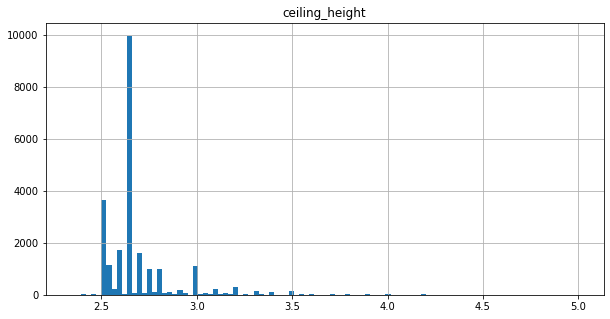

In [ ]:
# Высота потолков 
data_ceiling_max= data.query('ceiling_height>5')

print(data_ceiling_max['ceiling_height'].count())

data_living_min = data.query('living_area<20')
# заменяем аномальные значения высоты потолков
data.loc[data['ceiling_height'] >= 24, 'ceiling_height'] = data['ceiling_height'] / 10

display(data.loc[data['ceiling_height'] <= 2.3]) # проверим алгоритм замены

#data.loc[(data.ceiling_height <= 2.3), 'ceiling_height'] = 2.4 написал два варианта решения этой задачи - через loc и через where
data['ceiling_height'] = np.where((data.ceiling_height <= 2.3), 2.4, data.ceiling_height)


median_height = data.query('ceiling_height<5')
median_height= median_height['ceiling_height'].median()

display(data.loc[data['ceiling_height'] >= 5]) # проверим алгоритм замены
data.loc[(data.ceiling_height > 5), 'ceiling_height'] = median_height


# заменяем пропуски медианой 
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) 
display(data['ceiling_height'].describe()) # выводим обновленную информацию о высоте потолков
data.hist('ceiling_height', bins=100, figsize=(10,5))


In [ ]:
# check
data[data.index == 20520]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20520,9,3600000.00,38.00,2018-07-05,1,2.40,12.00,15.00,9,NaN,...,11.80,1.00,Кудрово,NaN,NaN,0.00,0.00,0.00,0.00,62.00


In [ ]:
# check
data[data.index == 20507]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20507,12,5950000.00,60.00,2018-02-19,2,2.65,14.00,35.00,11,NaN,...,13.00,1.00,Санкт-Петербург,27028.00,12570.00,0.00,0.00,0.00,0.00,40.00


In [ ]:
print(f' {median_height} - это медианное значение потолка')

 2.65 - это медианное значение потолка


In [ ]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Аномально больших значений в данном срезе 36 штук. Но, значения высоты потолка с 20 до 40 метров, скорее всего пользовательская ошибка ввода. Поэтому их необходимо уменьшить в 10 раз для приведения к нормальным значениям. Один результат в 100 метров - выброс. 

#### Столбец Студия

In [ ]:
#Проанализируем столбец studio
print(data.loc[data['studio'] == True, 'rooms'].unique())

[0 1]


Как видно, что в столбце studio присутствуют комнаты 0 и 1. Приведем столбец studio к однообразию, заменим все комнаты 1 на 0.

In [ ]:
data.loc[data['studio'] == True, 'rooms'] = 0 
print(data.loc[data['studio'] == True, 'rooms'].unique() )

[0]


#### Столбец Жил площадь

0       45.00
1       17.60
2       30.50
3       45.00
4       30.50
         ... 
23694   45.00
23695   45.00
23696   30.50
23697   30.50
23698   17.60
Name: living_area, Length: 23699, dtype: float64


<AxesSubplot:>

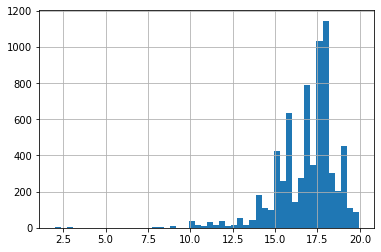

In [ ]:
data_median = data.groupby('rooms')['living_area'].transform('median')
print(data_median)
data['living_area'] = data['living_area'].fillna(data_median)
dd = data.query('living_area<20')
dd['living_area'].hist(bins=50)

На графике видно, что у нас есть аномальные значения жилой площади менее 7 метров. Так как их мало, можем их удалить.

In [ ]:
data = data.query('living_area > 7')

#### Стобец площадь кухни

<AxesSubplot:>

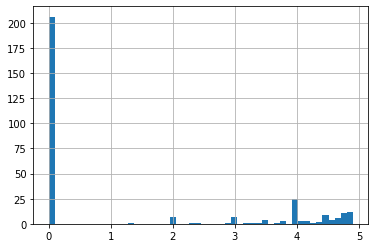

In [ ]:
# так как студиях кухонь нет, заменяем их на 0
data.loc[data['studio'] == True, 'kitchen_area'] = 0 

data_median = data.groupby('rooms')['kitchen_area'].transform('median')
data['kitchen_area'] = data['kitchen_area'].fillna(data_median)
ff = data.query('kitchen_area<5')
ff['kitchen_area'].hist(bins=50)

#### Стобцы балконы, апартаменты
- Пустые значения в столбце балконы заполняем 0, так как их скорей всего нет. 
- Пустые значения в столбце апартаменты заполняем -False, так как если продавец не указал, что это аппартаменты, то вероятнее всего это не они. 

In [ ]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].astype('int')
data['is_apartment'] = data['is_apartment'].fillna(value=False)

#### Оставшиеся столбцы
- Пустые значения дистанции до аэропорта заполнить нельзя, так как мы не можем привязать их ни к чему похожему. 
- Пустые значения в столбце названий населенных пунктов заполнить нельзя, так как в них должны стоять конкретные названия населенных пунктов.

### 2.5 Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты.

In [ ]:
#удалеям строки, где название населенного пункта пропущено
data = data.dropna(subset = ['locality_name'])

print(data['locality_name'].isnull().sum()) #проверим произошло ли удаление строк

0


In [ ]:
# выведем все уникальные значения столбца locality_name для выявления неявных дубликатов
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Так как в списке имеются названия населенных пунктов с буквами е и ё, то среди них возможно имеются населенные пункты с одинаковыми названиями. Приведем е и ё к 'е'

In [ ]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

In [ ]:
# check
data['locality_name'].nunique()

330

In [ ]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,642.00","23,642.00","23,642.00","20,462.00","23,642.00","23,642.00","23,642.00","23,642.00","23,557.00"
min,0.00,12.00,2.34,1.00,"12,190.00",8.00,0.00,1.00,1.00
max,19.00,900.00,5.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


In [ ]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,8022
2,7923
3,5796
4,1174
5,326
0,206
6,105
7,59
8,12
9,8


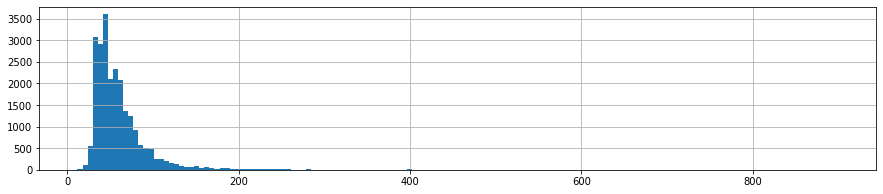

In [ ]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

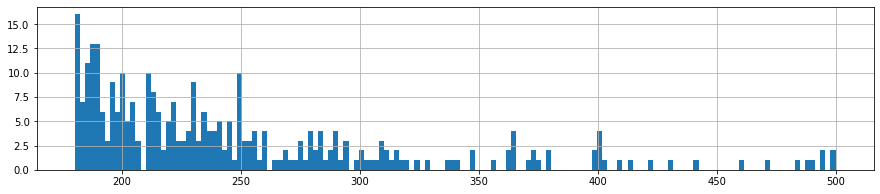

In [ ]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

In [ ]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.01,1.00,25.23,2.50,4.00,"1,000,000.00",13.10,4.00,1.00,2.00
0.5,2.00,52.00,2.65,95.00,"4,650,000.00",30.30,9.00,4.00,9.00
0.9,3.00,93.50,3.00,459.90,"10,900,000.00",54.60,15.15,13.00,22.00
0.9976,7.00,309.78,4.00,"1,311.68","82,000,000.00",180.00,50.00,25.00,27.00


In [ ]:
# выведем экстремальные значения столбцов, если они имеются
display(data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']].max())
print()
display(data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']].min())

rooms                    19.00
total_area              900.00
ceiling_height            5.00
days_exposition        1580.00
last_price        763000000.00
living_area             409.70
kitchen_area            112.00
floor                    33.00
floors_total             60.00
dtype: float64

rooms                 0.00
total_area           12.00
ceiling_height        2.34
days_exposition       1.00
last_price        12190.00
living_area           8.00
kitchen_area          0.00
floor                 1.00
floors_total          1.00
dtype: float64

Из выведенной информации видим, что у нас остались 
- выбивающиеся максимальные значения высоты потолка и цены;
- выбивающиеся минимальные значения высоты потолка, комнат и площадей.
Создадим срез без них

In [ ]:
# уберем редкие и выбивающиеся значения из таблицы
data = data.query('1< ceiling_height < 6') 
data = data.query('rooms >0')
data = data.query('last_price != 763000000.00')
data = data.query('living_area >10') 
data = data.query('living_area >2') 
data = data.query('kitchen_area >2')

display(data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']].max())
print()
display(data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']].min())

rooms                    19.00
total_area              900.00
ceiling_height            5.00
days_exposition        1580.00
last_price        420000000.00
living_area             409.70
kitchen_area            112.00
floor                    33.00
floors_total             60.00
dtype: float64

rooms                 1.00
total_area           13.00
ceiling_height        2.34
days_exposition       1.00
last_price        12190.00
living_area          10.08
kitchen_area          2.30
floor                 1.00
floors_total          1.00
dtype: float64

In [ ]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир


(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,804.00","22,804.00","22,804.00","19,706.00","22,804.00","22,804.00","22,804.00","22,804.00","22,804.00"
min,1.00,13.00,2.34,1.00,12.19,10.08,2.30,1.00,1.00
max,11.00,199.20,5.00,"1,000.00","330,000.00",164.70,93.20,33.00,37.00


In [ ]:
# посмотрим на этажность в объявлениях. 
data['floors_total'].value_counts(ascending=False).to_frame()
# видим, что есть два объявления о продаже квартир на этажах 52 и 60. В Ленинградской области мкд такой этажности нет. 
#Уберем их.

,floors_total
5.00,5750
9.00,3742
16.00,1357
12.00,1351
4.00,1188
10.00,1166
25.00,1047
6.00,905
17.00,813
3.00,660


In [ ]:
data = data.query('floors_total < 50')
data['floors_total'].value_counts(ascending=False).to_frame()

,floors_total
5.00,5750
9.00,3742
16.00,1357
12.00,1351
4.00,1188
10.00,1166
25.00,1047
6.00,905
17.00,813
3.00,660


In [ ]:
data = data.query('last_price != 12.19')
# проверим обновленные данные
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,296.00","23,296.00","23,296.00","20,146.00","23,296.00","23,296.00","23,296.00","23,296.00","23,296.00"
min,1.00,13.00,2.34,1.00,"12,190.00",10.08,2.30,1.00,1.00
max,19.00,900.00,5.00,"1,580.00","420,000,000.00",409.70,112.00,33.00,37.00


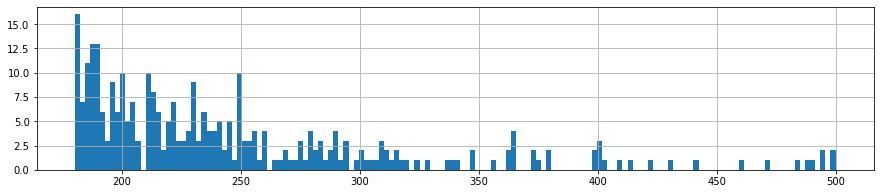

In [ ]:
# площадей квартир от 200 метров немного. Для нас в анализе данных это является выбросом, их можно убрать.

data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

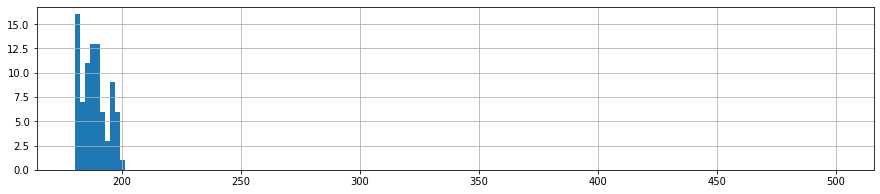

In [ ]:
data = data.query('total_area < 200')
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

## 3. Посчитайте и добавьте в таблицу новые столбцы

Добавьте в таблицу новые столбцы со следующими параметрами: день недели публикации объявления (0 — понедельник, 1 — вторник и так далее); месяц публикации объявления; год публикации объявления; 

In [ ]:
# Добавим столбцы c днем, месяцем и годом

data['day'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

display(data.loc[:,['first_day_exposition', 'day', 'month', 'year']])

,first_day_exposition,day,month,year
0,2019-03-07,3,3,2019
1,2018-12-04,1,12,2018
2,2015-08-20,3,8,2015
3,2015-07-24,4,7,2015
4,2018-06-19,1,6,2018
...,...,...,...,...
23694,2017-03-21,1,3,2017
23695,2018-01-15,0,1,2018
23696,2018-02-11,6,2,2018
23697,2017-03-28,1,3,2017


### 3.1 Добавьте в таблицу новые столбцы со следующими параметрами: цена одного квадратного метра

In [ ]:
data['price_per_meter'] = data['last_price'] / data['total_area']
display(data['price_per_meter'])

0       120370.37
1        82920.79
2        92785.71
3       408176.10
4       100000.00
           ...   
23694    72490.85
23695    52542.37
23696    44091.71
23697   149511.40
23698    41795.67
Name: price_per_meter, Length: 23068, dtype: float64

### 3.2 Добавьте в таблицу новые столбцы со следующими параметрами: тип этажа квартиры (значения — «первый», «последний», «другой»); расстояние до центра города в километрах (переведите из м в км и округлите до целых значений). 

array([16, 11,  5, 14, 12, 26, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4,
       22,  8,  2, 10,  7, 13, 15, 20, 28, 36, 21, 35, 34,  1, 29, 33, 37])

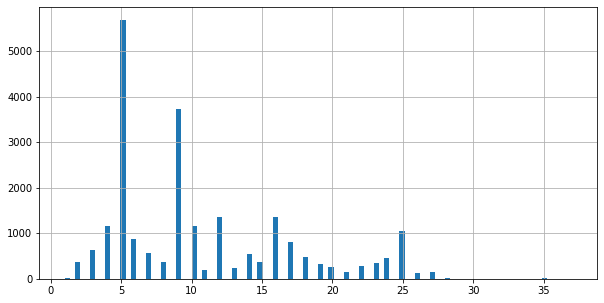

In [ ]:
#проверим столбец floors_total на пропуски и аномальные значения
data['floors_total'].isnull().sum()
data['floors_total'].hist(bins=100, figsize=(10,5))

data = data.dropna(subset = ['floors_total'])

data['floors_total'].isnull().sum()
data['floors_total'] = data['floors_total'].astype('int')
data['floors_total'].unique()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23068 entries, 0 to 23698
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23068 non-null  int64         
 1   last_price            23068 non-null  float64       
 2   total_area            23068 non-null  float64       
 3   first_day_exposition  23068 non-null  datetime64[ns]
 4   rooms                 23068 non-null  int64         
 5   ceiling_height        23068 non-null  float64       
 6   floors_total          23068 non-null  int64         
 7   living_area           23068 non-null  float64       
 8   floor                 23068 non-null  int64         
 9   is_apartment          23068 non-null  bool          
 10  studio                23068 non-null  bool          
 11  open_plan             23068 non-null  bool          
 12  kitchen_area          23068 non-null  float64       
 13  balcony         

In [ ]:
# добавим в таблицу новый столбец с параметрами типа этажа 

def floor_group(row):
  floor = row['floor']
  floors_total = row['floors_total']
  if (floor == 1) | (floor == 0):
    return 'первый'
  if (floor == floors_total):
    return 'последний'
  return 'другой'
data['floor_group']= data.apply(floor_group, axis=1)
data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 23068 entries, 0 to 23698
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23068 non-null  int64         
 1   last_price            23068 non-null  float64       
 2   total_area            23068 non-null  float64       
 3   first_day_exposition  23068 non-null  datetime64[ns]
 4   rooms                 23068 non-null  int64         
 5   ceiling_height        23068 non-null  float64       
 6   floors_total          23068 non-null  int64         
 7   living_area           23068 non-null  float64       
 8   floor                 23068 non-null  int64         
 9   is_apartment          23068 non-null  bool          
 10  studio                23068 non-null  bool          
 11  open_plan             23068 non-null  bool          
 12  kitchen_area          23068 non-null  float64       
 13  balcony         

In [ ]:
# добавим столбец расстояние до центра города в километрах.
data['city_centers_nearest_km'] = (data['cityCenters_nearest']/1000).round()
data['city_centers_nearest_km'].isna().sum() 

# в столбце присутствуют пропущенные значения. Для округления до целых числе, необходимо изменить тип данных столбца на int
# поэтому заменим пропуски на 0
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].fillna(0)
data['city_centers_nearest_km'].isna().sum()
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].astype(int)
print(data['city_centers_nearest_km'])     

0        16
1        19
2        14
3         7
4         8
         ..
23694     4
23695     0
23696     0
23697    10
23698     0
Name: city_centers_nearest_km, Length: 23068, dtype: int64


## 4. Проведите исследовательский анализ данных

### 4.1 Изучите следующие параметры объектов:  

1.   общая площадь
2.   жилая площадь
3.   площадь кухни;
4.   цена объекта; 
5.   количество комнат; 
6.   высота потолков; 
7.   этаж квартиры; 
8.   тип этажа квартиры («первый», «последний», «другой»); 
9.   общее количество этажей в доме; 
10.  расстояние до центра города в метрах; 
11.  расстояние до ближайшего аэропорта; 
12.  расстояние до ближайшего парка; 
13.  день и месяц публикации объявления. 

Постройте отдельные гистограммы для каждого из этих параметров. 
Опишите все ваши наблюдения по параметрам в ячейке с типом markdown. 


#### общая площадь

<AxesSubplot:>

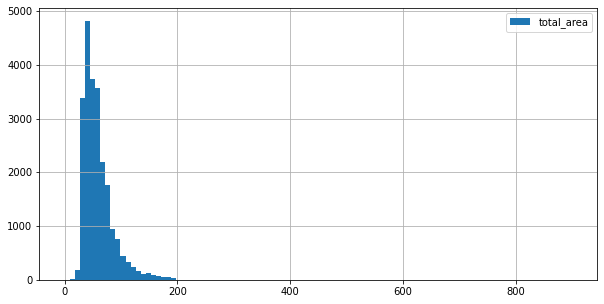

In [ ]:
data['total_area'].hist(range=(0,900),legend=True, bins=100, figsize=(10,5))
#ax.set_xlabel('общая площадь')
#ax.set_ylabel('количество квартир')
 

<AxesSubplot:>

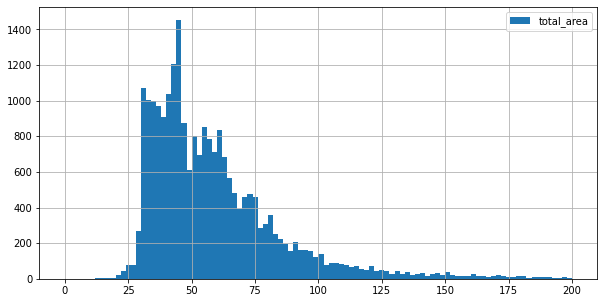

In [ ]:
# отфильтрованные значения до 200 метров, так как большая часть объявлений располагается в этом диапазоне
data['total_area'].hist(range=(0,200),legend=True, bins=100, figsize=(10,5))

<AxesSubplot:>

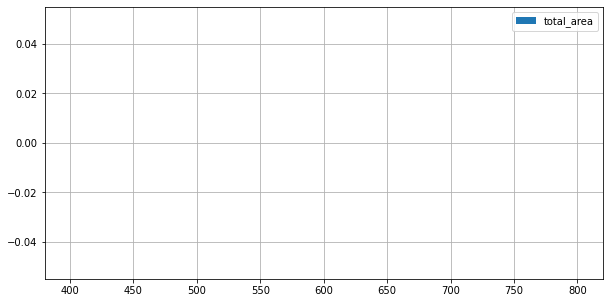

In [ ]:
# выбросы
data['total_area'].hist(range=(400,800),legend=True, bins=100, figsize=(10,5))

ВЫВОД: Чаще всего общая площадь квартир в объявлениях находится в промежутке от 30 до 45 метров. Но также есть выбросы свыше 400 метров.

#### жилая площадь

<AxesSubplot:>

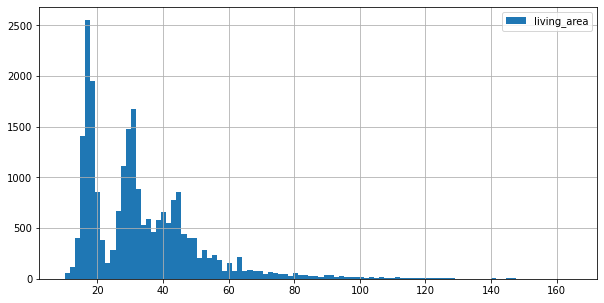

In [ ]:

data['living_area'].hist(legend=True, bins=100,figsize=(10,5))

<AxesSubplot:>

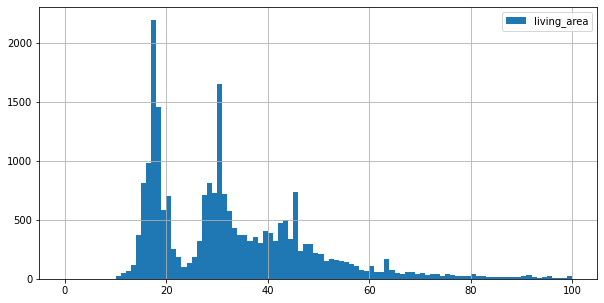

In [ ]:
# отфильтрованные значения до 100 метров, так как большая часть объявлений располагается в этом диапазоне
data['living_area'].hist(range=(0,100),legend=True, bins=100,figsize=(10,5))

<AxesSubplot:>

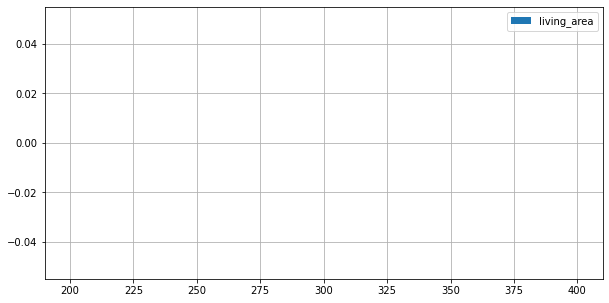

In [ ]:
# выбросы
data['living_area'].hist(range=(200,400),legend=True, bins=50,figsize=(10,5))

ВЫВОД: Чаще всего жилая площадь квартир в объявлениях находится в промежутке от 25 до 35 метров. Но также есть выбросы свыше 200 метров. Первый пик в районе 20 метров связан с тем, что неподходящие значения жилой площади были заменены на медианные значения.

#### площадь кухни

<AxesSubplot:>

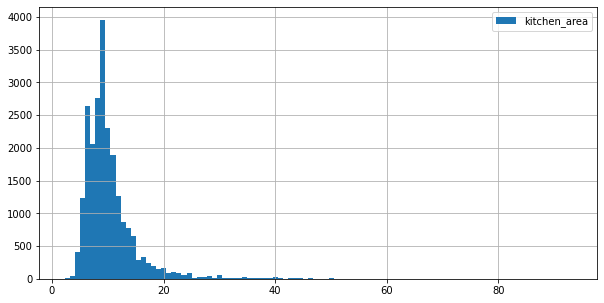

In [ ]:

data['kitchen_area'].hist(legend=True,bins=100,figsize=(10,5))

<AxesSubplot:>

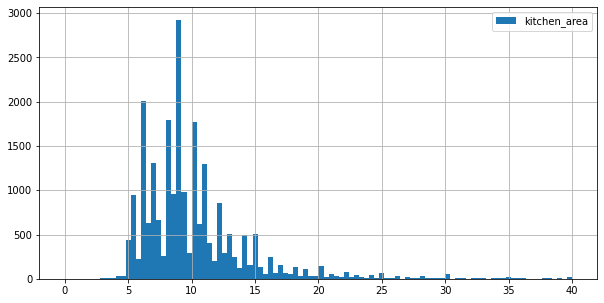

In [ ]:
# площадь кухни без выбросов
data['kitchen_area'].hist(range=(0,40), legend=True,bins=100,figsize=(10,5))

<AxesSubplot:>

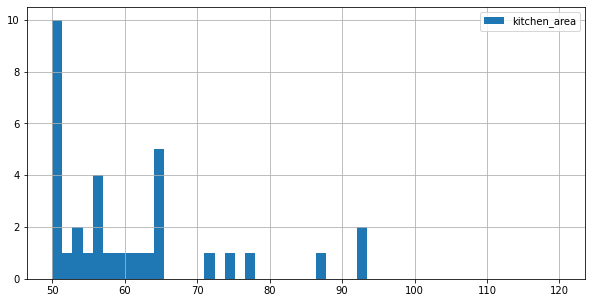

In [ ]:
# выбросы
data['kitchen_area'].hist(range=(50,120), legend=True,bins=50,figsize=(10,5))

ВЫВОД: на гисторгамме видно несколько пиков значений площади кухни, но можно сделать вывод, что площадь кухонь в большинстве объявлений составляет от 6 до 10 метров кв.

#### цена объекта

count       23068.00
mean      6049330.41
std       6250664.48
min         12190.00
5%        1850000.00
25%       3450000.00
50%       4630000.00
95%      14105525.00
99%      27866500.00
max     330000000.00
Name: last_price, dtype: float64

<AxesSubplot:>

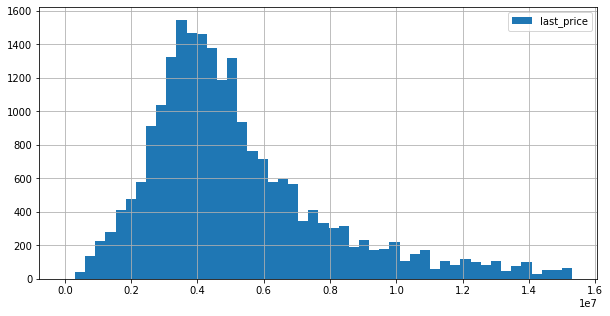

In [ ]:
display(data['last_price'].describe(percentiles=[0.05, 1/4, 1/2, 0.95, 0.99]))

# если вывести гистограмму по всем ценам, она будет нечитабельна. Поэтому делаем верхний срез по 95%
data['last_price'].hist(range=(0,15300000), legend=True, bins=50, figsize=(10,5))


<AxesSubplot:>

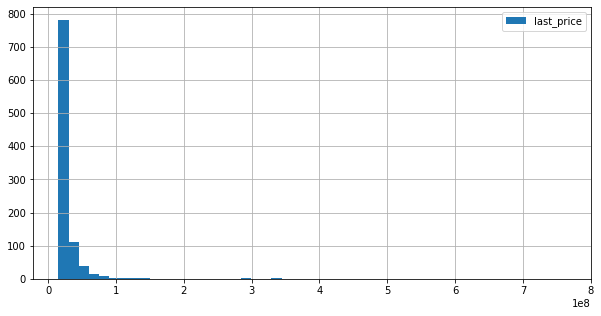

In [ ]:
data['last_price'].hist(range=(15300000, 763000000), legend=True, bins=50, figsize=(10,5))

ВЫВОД: Медиана квартир выставленных на продажу - 4,65 млн. руб., среднее - 6,54 млн. руб. Такое различие возникает из за аномально высоких выбросов - более 700 млн. руб.

#### количество комнат

<AxesSubplot:>

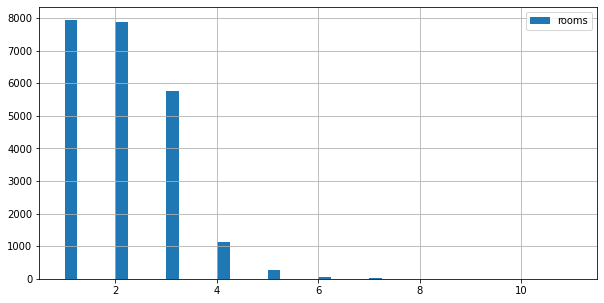

In [ ]:

data['rooms'].hist(legend=True, bins=40, figsize=(10,5))

ВЫВОД: Основное количество объявлений приходится на одну и двухкомнатные квартиры. Но имеются объявления, в которых указано более 10 комнат.

#### высота потолков

count   23068.00
mean        2.69
std         0.21
min         2.34
25%         2.60
50%         2.65
75%         2.70
max         5.00
Name: ceiling_height, dtype: float64

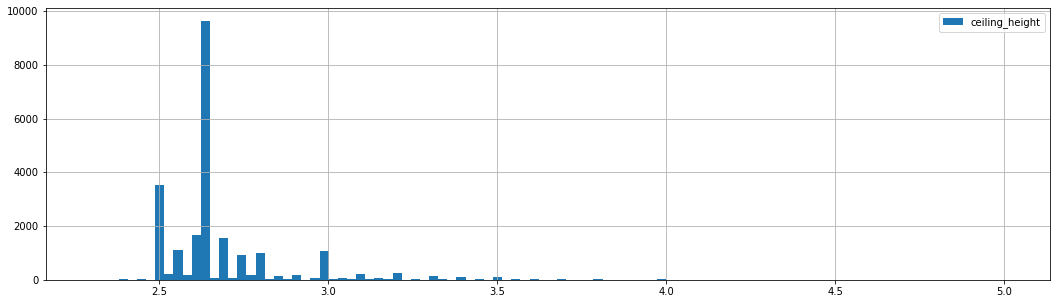

In [ ]:
data['ceiling_height'].hist(range=(2.3,5), legend=True, bins=100, figsize=(18,5))
data['ceiling_height'].describe()

ВЫВОД: На графике высоты потолка имеется пик в 2,65 м.Это добавленное медианное значение, которым мы заменили все значения свыше 6 метров. Так как в данном проекте для анализа высота потолка не важна, то оставляем медианное значение.

#### этаж квартиры

<AxesSubplot:>

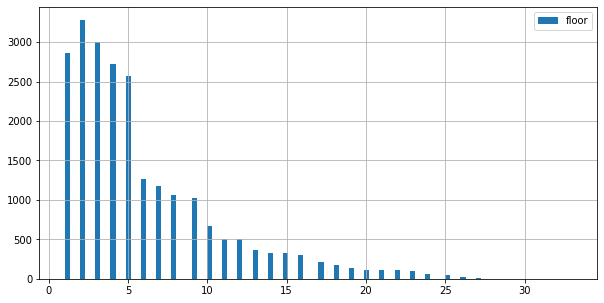

In [ ]:

data['floor'].hist(legend=True, bins=100, figsize=(10,5))

ВЫВОД: Основное количество квартир в объявлениях располагается в пределах пяти этажей.

#### тип этажа квартиры («первый», «последний», «другой»)

<AxesSubplot:>

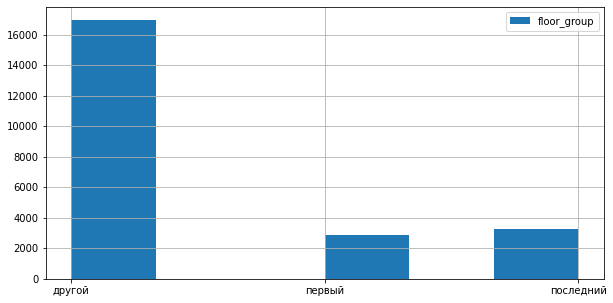

In [ ]:
data['floor_group'].hist(legend=True, bins=6, figsize=(10,5))

ВЫВОД: Квартир на первом и последнем этажах в объявлениях попадается меньше, так как их доля сравнении с числом квартир на всех остальных этажах - мала.

#### общее количество этажей в доме

<AxesSubplot:>

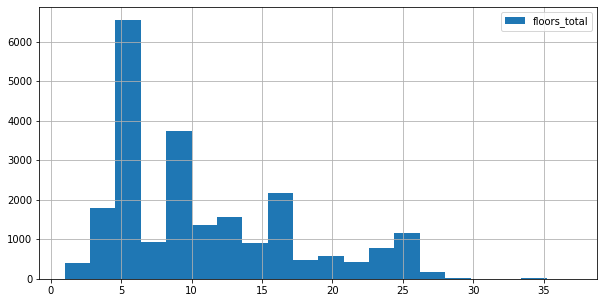

In [ ]:
data['floors_total'].hist(legend=True, bins=20, figsize=(10,5))

ВЫВОД: Большинство продаваемых квартир располагается в домах невысокой этажности. От 5 до 10 этажей.

#### расстояние до центра города

<AxesSubplot:>

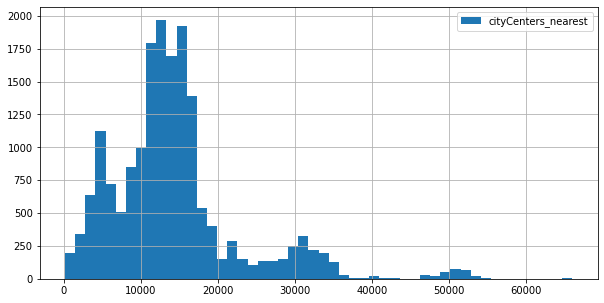

In [ ]:
# в метрах
data['cityCenters_nearest'].hist(legend=True, bins=50, figsize=(10,5))

<AxesSubplot:>

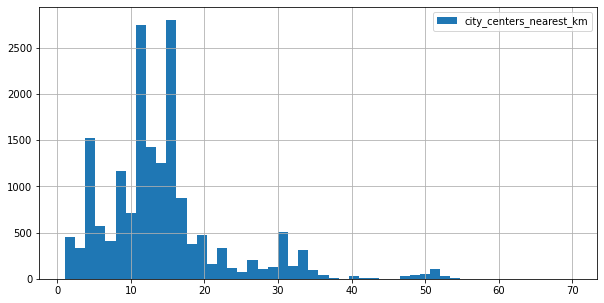

In [ ]:
# в километрах
data['city_centers_nearest_km'].hist(range=(1,70), legend=True,  bins=50, figsize=(10,5))

ВЫВОД: Большинство квартир продается на окраине Санкт-Петербурга (11-18 км от центра) 

#### расстояние до ближайшего аэропорта

<AxesSubplot:>

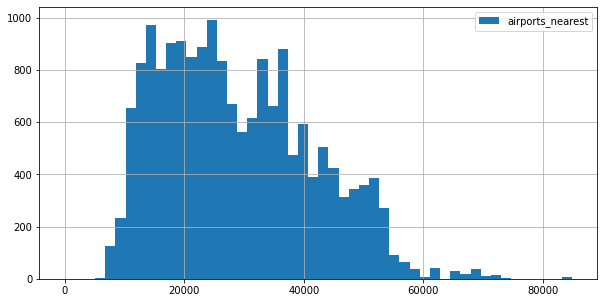

In [ ]:
data['airports_nearest'].hist(legend=True, bins=50, figsize=(10,5))

ВЫВОД: В среднем квартиры располагаются в 26-28 км от ближайшего аэропорта

#### расстояние до ближайшего парка

<AxesSubplot:>

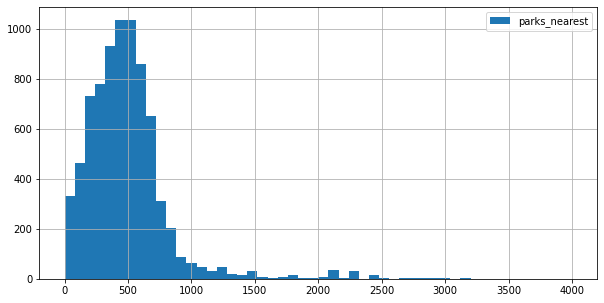

In [ ]:

data['parks_nearest'].hist(range=(1,4000), legend=True, bins=50, figsize=(10,5))

ВЫВОД: Рядом с большинством продаваемых квартир имеется парк в пешей доступности. Это большой плюс для города с несколькими миллионами населения.

#### день и месяц публикации объявления

<AxesSubplot:>

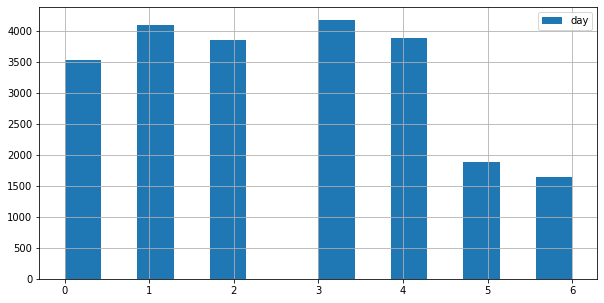

In [ ]:

data['day'].hist(legend=True, bins=14,figsize=(10,5))

<AxesSubplot:>

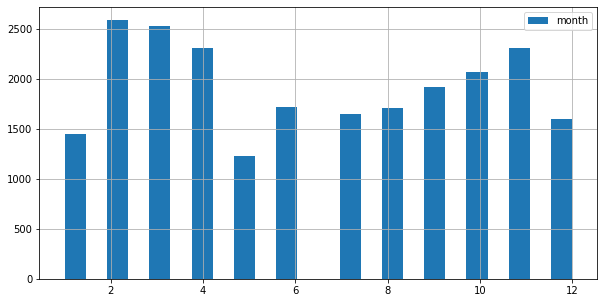

In [ ]:
data['month'].hist(legend=True, bins=24, figsize=(10,5))

ВЫВОД: На графиках видно, что квартиры чаще выставляют на продажу во вторник и четверг, а также в холодные месяцы года. 

### 4.2 Какие факторы больше всего влияют на общую (полную) стоимость объекта? 
Изучите, зависит ли цена от: 
1.   общей площади; 
2.   жилой площади; 
3.   площади кухни; 
4.   количества комнат; 
5.   этажа, на котором расположена квартира (первый, последний, другой); 
6.   даты размещения (день недели, месяц, год). 


Постройте графики, которые покажут зависимость цены от указанных выше параметров. 
Для подготовки данных перед визуализацией вы можете использовать сводные таблицы. 


count   19970.00
mean      180.28
std       218.83
min         1.00
5%          9.00
25%        45.00
50%        95.00
95%       643.00
99%      1064.31
max      1580.00
Name: days_exposition, dtype: float64

<AxesSubplot:>

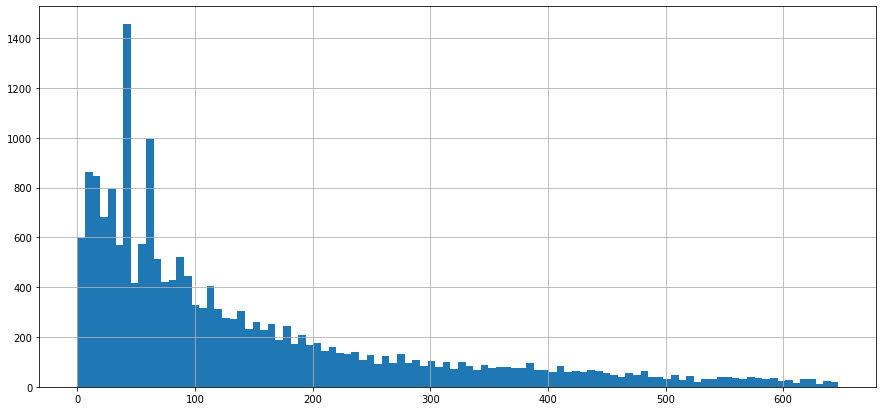

In [ ]:
display(data['days_exposition'].describe(percentiles=[0.05, 1/4, 1/2, 0.95, 0.99]))
data['days_exposition'].hist(range=(0,647), bins=100, figsize=(15, 7))


#### зависит ли цена от количества комнат

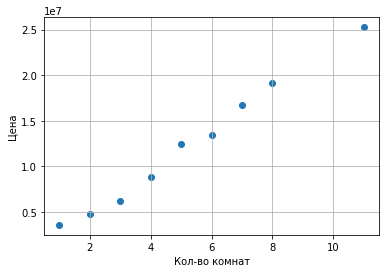

In [ ]:
room_price = data.pivot_table(index='rooms', values='last_price', aggfunc='median')

plt.scatter(room_price.index, room_price)
plt.grid()
plt.xlabel('Кол-во комнат')
plt.ylabel('Цена')
plt.show()

In [ ]:
# вычислим корреляцию данного параметра
print(data['rooms'].corr(data['last_price']))

0.37787738699343654


ВЫВОД: есть тенденция небольшого увеличения цены квартиры от увеличения количества комнат в ней. Также на графике имеется аномальное значение цены квартиры с 12 комнатами.

#### зависит ли цена от общей площади

<AxesSubplot:xlabel='last_price', ylabel='total_area'>

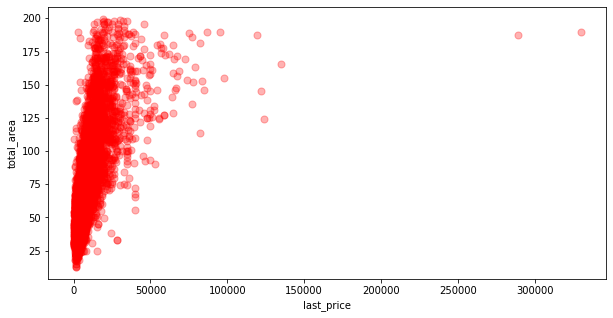

In [ ]:

data['last_price'] = data['last_price']/1000 #для удобства разделим значения цен квартир на 1000 и приведем к тыс. рублей


data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.3, figsize=(10,5), c = [[1, 0, 0, 0.05]], s=50)
# здесь я попробовал поиграть с видом графика

In [ ]:
# вычислим корреляцию данного параметра
print(data['total_area'].corr(data['last_price']))

0.658320539407368


#### зависит ли цена от жилой площади

<AxesSubplot:xlabel='last_price', ylabel='living_area'>

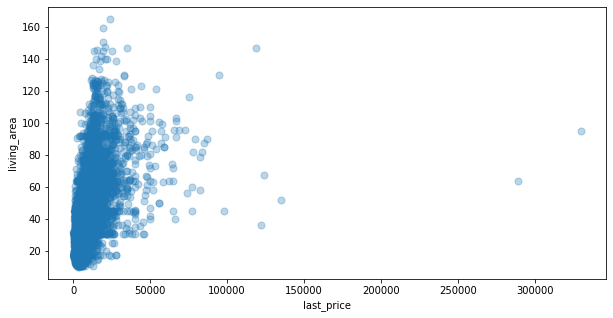

In [ ]:
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.3, figsize=(10,5), s=50)

In [ ]:
# вычислим корреляцию данного параметра
print(data['living_area'].corr(data['last_price']))

0.5283275119275727


#### зависит ли цена от площади кухни

<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

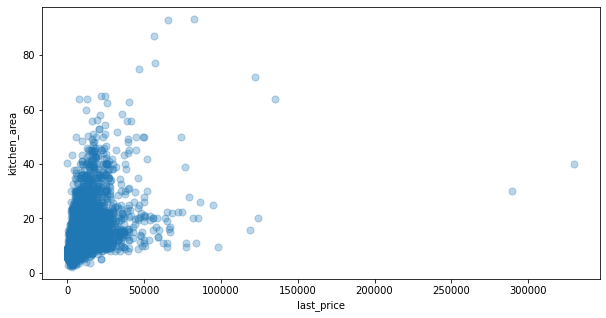

In [ ]:
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.3, figsize=(10,5), s=50)

In [ ]:
# вычислим корреляцию данного параметра
print(data['kitchen_area'].corr(data['last_price']))

0.50463630182919


ВЫВОД: Исходя из построенных графиков, можно сказать, что имеется тенденция увеличения цены квартиры взависимости от увеличения её общей площадей, включая кухню и жилую площадь. Корреляции цены от жилой площади и размера кухни говорят о наличии связи, однако не слишком сильной. Однако, корреляция цены от общей площади больше и составляет 0,65.

#### зависит ли цена от этажа, на котором расположена квартира (первый, последний, другой);

<AxesSubplot:xlabel='floor_group'>

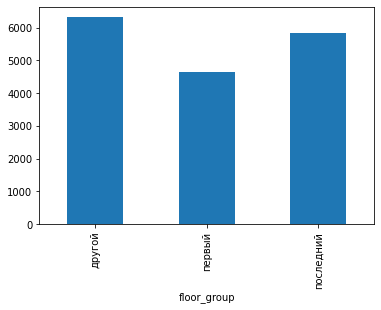

In [ ]:
data.groupby('floor_group')['last_price'].mean().plot.bar()

Вычислить корреляцию столбца 'floor_group' не представляется возможным, так как значения этого столбца не числовые

#### зависит ли цена от даты размещения (день недели, месяц, год).

<AxesSubplot:xlabel='year'>

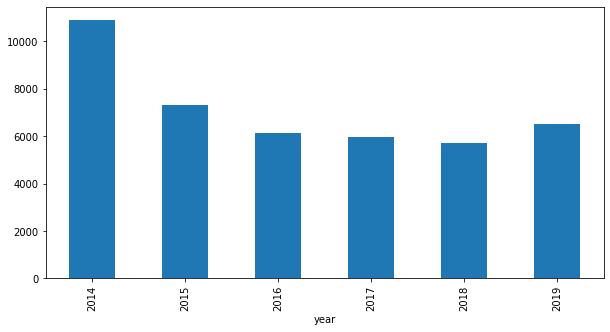

In [ ]:
data.groupby('year')['last_price'].mean().plot.bar(figsize=(10,5))

ВЫВОД: Общая тенденция, кроме 2019 года была нисходящая. С 2019 цены средняя цена за квартиру снова начала расти. 

<AxesSubplot:xlabel='day'>

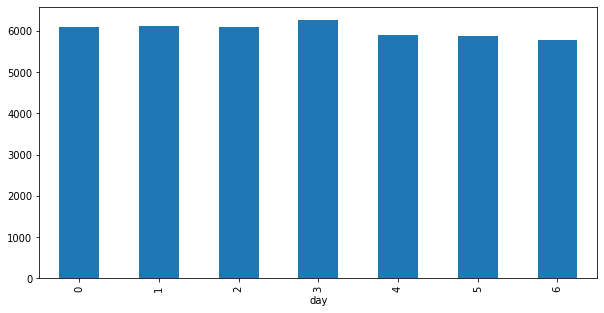

In [ ]:
data.groupby('day')['last_price'].mean().plot.bar(figsize=(10,5))

ВЫВОД: Какой-либо зависимости цены от дня недели не наблюдается.

<AxesSubplot:xlabel='month'>

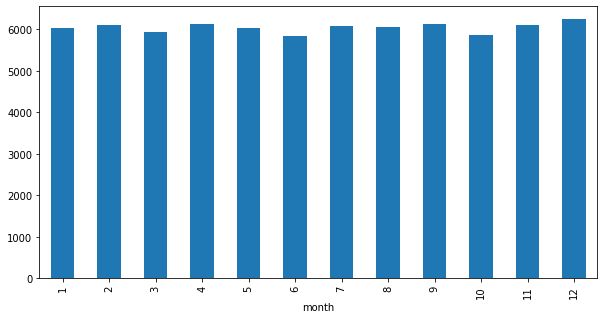

In [ ]:
data.groupby('month')['last_price'].mean().plot.bar(figsize=(10,5))

ВЫВОД: Аналогично и для месяцев.

#### Изучите, как быстро продавались квартиры (столбец days_exposition). 

- Постройте гистограмму. 
- Посчитайте среднее и медиану. 

В ячейке типа markdown опишите, сколько времени обычно занимает продажа. 
- Какие продажи можно считать быстрыми
- какие — необычно долгими? 

In [ ]:
# для начала посмотрим на статистическое распределение с помощью describe
display(data['days_exposition'].describe(percentiles=[0.05, 1/4, 1/2, 0.95]))

count   19970.00
mean      180.28
std       218.83
min         1.00
5%          9.00
25%        45.00
50%        95.00
95%       643.00
max      1580.00
Name: days_exposition, dtype: float64

array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

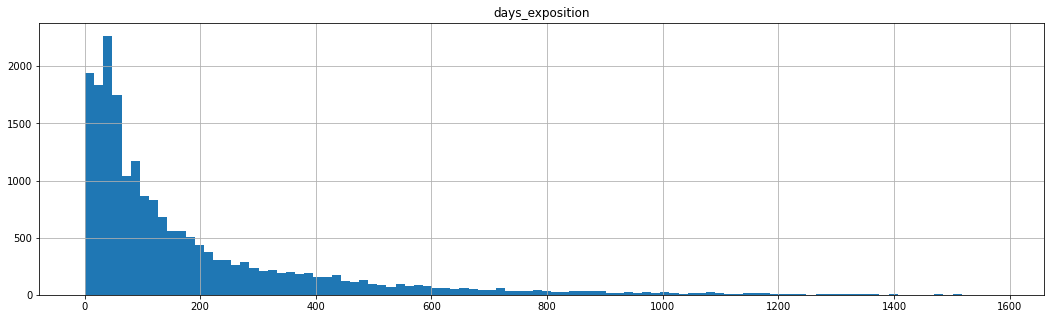

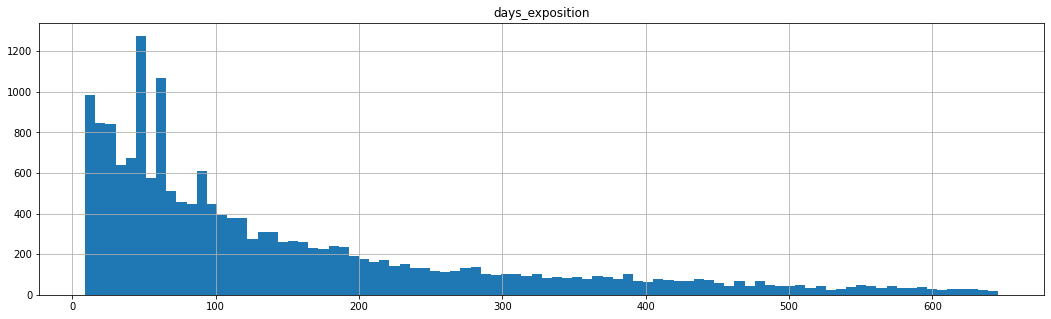

In [ ]:
# построим гистограммы
# гистограмма общая
data.hist('days_exposition', bins=100, figsize=(18, 5))
# гистограмма от 5% до 90%
data.hist('days_exposition', bins=90, figsize=(18, 5), range=(9, 646))


ВЫВОД: Среднее и медианное время продажи отличаются почти в два раза - 181 и 95 дней соответственно. Такое различие обусловленно крайне долгими продажами - свыше 600 дней. Кроме того, в первые 5% графика попадают и значения менее 9 дней, такие продажи можно считать сверхбыстрыми.

## 4.3 Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 
Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name. 
Ранее вы посчитали расстояние до центра в километрах. 
Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. 
Опишите, как стоимость объектов зависит от расстояния до центра города. 


In [ ]:
#средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 

display(data.pivot_table(index='locality_name', 
                            values=['price_per_meter', 'last_price'], 
                            aggfunc={'price_per_meter':['count', 'median', 'mean'], 'last_price': ['median', 'mean']})
        .sort_values(by=[('price_per_meter','count')], ascending=False).head(10)
)
display(data.pivot_table(index='locality_name', 
                        values=['price_per_meter', 'last_price'], 
                        aggfunc={'price_per_meter':['count', 'median', 'mean'], 'last_price': ['median', 'mean']})
    .sort_values(by=[('last_price','mean')], ascending=False).head(10)
)

last_price         price_per_meter                    
                        mean  median           count      mean    median
locality_name                                                           
Санкт-Петербург      7346.54 5500.00           15276 113420.74 104444.44
поселок Мурино       3721.31 3439.25             522  84859.05  84262.42
поселок Шушары       4124.55 3970.00             434  78303.21  76747.97
Всеволожск           3818.88 3500.00             392  68618.01  65789.47
Пушкин               6159.80 5150.00             363 103120.75  99987.18
Колпино              3866.29 3600.00             337  75333.30  74722.22
поселок Парголово    4508.86 4140.00             321  90418.67  91917.59
Гатчина              3488.34 3100.00             307  68746.15  67796.61
деревня Кудрово      4348.05 3800.00             280  92234.55  91618.22
Выборг               3257.13 2898.50             236  58094.92  58133.21

last_price          price_per_meter            \
                              mean   median           count      mean   
locality_name                                                           
поселок Репино            12166.85  8083.71               4 104238.61   
деревня Бор               10397.60 10397.60               2  59348.58   
поселок Александровская    8725.00  8725.00               2  70262.81   
Санкт-Петербург            7346.54  5500.00           15276 113420.74   
Сестрорецк                 6308.60  5470.00             180 101897.76   
Зеленогорск                6288.34  4750.00              24 115122.80   
Пушкин                     6159.80  5150.00             363 103120.75   
Павловск                   4929.71  3975.00              38  84067.07   
деревня Заневка            4781.50  4000.00               6  77662.57   
деревня Мистолово          4770.11  4090.00              11  98549.98   

                                   
                           median  
locality_name                      
поселок Репино           86542.21  
деревня Бор              59348.58  
поселок Александровская  70262.81  
Санкт-Петербург         104444.44  
Сестрорецк               99719.04  
Зеленогорск             101666.67  
Пушкин                   99987.18  
Павловск                 85410.20  
деревня Заневка          72769.46  
деревня Мистолово        90888.89

In [ ]:
#Выделите населённые пункты с самой высокой стоимостью квадратного метра.
(data.pivot_table(index='locality_name', values='price_per_meter', aggfunc='mean')
 .sort_values(by='price_per_meter', ascending=False).head())

,price_per_meter
locality_name,
Зеленогорск,115122.80
Санкт-Петербург,113420.74
поселок Репино,104238.61
Пушкин,103120.75
Сестрорецк,101897.76


In [ ]:
#Выделите населённые пункты с самой низкой стоимостью квадратного метра.
(data.pivot_table(index='locality_name', values='price_per_meter', aggfunc='mean')
 .sort_values(by='price_per_meter', ascending=False).tail())

,price_per_meter
locality_name,
поселок Совхозный,12629.13
деревня Выскатка,12335.48
деревня Вахнова Кара,11688.31
поселок станции Свирь,11481.48
деревня Старополье,11206.22


Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. 
Опишите, как стоимость объектов зависит от расстояния до центра города

In [ ]:
piter_price = (data.query('locality_name == "Санкт-Петербург"')
               .pivot_table(index='city_centers_nearest_km', values=['last_price', 'price_per_meter'], 
                            aggfunc='mean').reset_index())
display(piter_price.head(20))

,city_centers_nearest_km,last_price,price_per_meter
0,0,16682.80,175805.77
1,1,16503.34,164834.45
2,2,13640.24,150063.23
3,3,10341.46,120728.57
4,4,10825.63,127928.77
5,5,11573.66,136955.80
6,6,12392.69,147022.17
7,7,13740.36,155035.03
8,8,8978.37,124745.46
9,9,6937.40,112960.43


<AxesSubplot:xlabel='city_centers_nearest_km'>

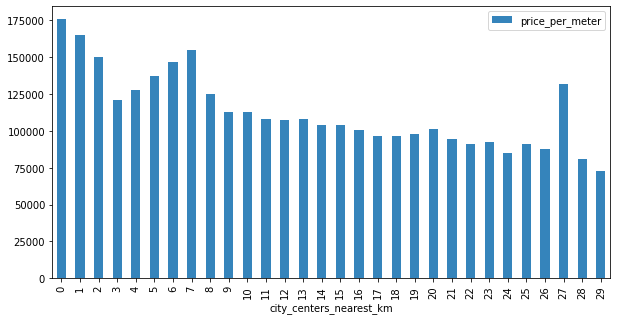

In [ ]:
piter_price.plot(x='city_centers_nearest_km', y='price_per_meter', kind='bar', alpha=0.9, figsize=(10,5))

ВЫВОД: По таблице видим, что средняя цена квадратного метра, как и средняя цена квартиры становится ниже с каждым километром от центра города. График это подтверждает. Выброс на 27 км от центра города имеется из-за дорогой квартиры

## 5. Общий вывод


При работе с проектом я провел предобработку данных - удалил пропуски, заменил некорректные значения. Часть некорректных данных скроее всего была занесена самими пользователями при наборе объявления. Часть пропусков была логична, например, пропуски в столбцах парки, пруды и балконы. Если их не указывали, значит их нет. Пропуски в столбцах, где указывается расстояние до центра или аэропорта логичны, так как пользователь не всегда имеет под рукой такую информацию. 
Анализом установлено, что средняя цена за квадратный метр, как и средняя цена за квартиру падает при удалении от центра Санкт-Петербурга. В среднем, квартира продается за пол года. 

Так же цена квартиры зависит от ее площади и количества комнат в ней. Чем больше, тем дороже. Что логично. Это подтверждается корреляцией в 0,65 между ценой и общей площадью квартиры.

Выяснили, что квартиры в Санкт-Петербурге в среднем стоят дороже, чем в остальных наседенных пунктах. Средняя цена на квартиру там составляет 8 млн. руб., тогда как в Выборге одни из самых дешёвых цен на жилплощадь. Средняя цена на их квартиры - 3.2 млн. руб. 



Рекомендации сайту по продаже квартир:
--
- при вводе важных данных, таких как адрес, количество комнат и цена пользователю необходимо указать о важности их заполнения и не дать опубликовать такое объявление. 
- ограничить численный ввод значений в параметрах в пределах реальных показателей для избежания неверного ввода. К примеру - потолка высотой в 100 метров или 5 балконов в однокомнатной квартире.
- последовать примеру объявлений о продаже квартир из Москвы и включить расстояние до ближайшей станции метро.
